# Model Selection
Preliminary model assessment showed performance of classification algorithms performing better than regression.   Thus, for the purposes of this notebook, only classification algorithms are explored.

In [2]:
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3

import pickle
import joblib

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from yellowbrick.classifier import ClassificationReport

In [5]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [6]:
conn = sqlite3.connect('../data/crime_census_weather_tod.db')
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('all_crimes',), ('by_crime_type',)]


In [44]:
conn = sqlite3.connect('../data/crime_census_weather_tod.db')
df = pd.read_sql_query("SELECT * FROM all_crimes", conn)
conn.close()

In [46]:
df['crime_rate_cat'].unique()

array(['Med', 'High', 'Med-High', 'Low', 'Low-Med'], dtype=object)

In [47]:
cats = list(df['crime_rate_cat'].unique())

In [8]:
df.head(500)

,level_0,BLOCK_GROUP,year,month,day,tod_cat,tod_num,crime_counts,apparent_temp,cloud_cover,dew_point,humidity,percip_intensity,percip_probability,pressure,temperature,uv_index,visibility,wind_bearing,wind_gust,wind_speed,weekday,index,TotalPop,TPopMargin,UnWgtSampleCtPop,PerCapitaIncome,PerCapIncMargin,MedianHouseholdInc,MedHouseholdIncMargin,MedianAge,MedianAgeMargin,HousingUnits,HousingUnitsMargin,UnweightedSampleHousingUnits,State,County,Tract,BlockGroup,census_year,crime_rate,crs,crime_rate_cat
0,0,000100 1,2009,1,10,Midnight,8.0,1,32.58,1.000,19.160000,0.570000,0.0000,0.000,1024.950000,32.580,0.0,6.32,80.000000,2.12,0.740000,5,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med
1,1,000100 1,2009,1,16,Mid Afternoon,5.0,1,7.21,0.060,-7.120000,0.330000,0.0000,0.000,1036.650000,16.750,2.0,4.18,302.000000,15.24,6.890000,4,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med
2,2,000100 1,2009,1,31,Afternoon,4.0,1,19.62,0.000,4.980000,0.400000,0.0000,0.000,1021.060000,26.050,3.0,5.19,310.000000,12.60,5.480000,5,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med
3,3,000100 1,2009,2,6,Evening,6.0,1,36.77,0.030,14.130000,0.390000,0.0000,0.000,1028.140000,36.770,0.0,4.96,128.000000,1.52,0.640000,4,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med
4,4,000100 1,2009,6,25,Evening,6.0,3,87.71,0.080,62.456667,0.443333,0.0000,0.000,1008.306667,87.050,1.0,5.43,235.666667,2.76,0.913333,3,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,231.303007,3.557247,High
5,5,000100 1,2009,6,25,Night,7.0,2,79.22,0.060,65.585000,0.640000,0.0000,0.000,1008.460000,78.625,0.0,6.28,208.500000,0.91,0.270000,3,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,154.202005,3.390185,Med-High
6,6,000100 1,2009,6,26,Evening,6.0,1,91.32,0.430,70.660000,0.600000,0.0000,0.000,1005.320000,86.060,1.0,5.66,220.000000,3.50,1.220000,4,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med
7,7,000100 1,2009,7,1,Morning,3.0,1,76.43,0.110,66.280000,0.730000,0.0000,0.000,1006.060000,75.750,5.0,5.86,338.000000,2.16,0.170000,2,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med
8,8,000100 1,2009,7,10,Mid Afternoon,5.0,1,78.87,0.690,59.860000,0.520000,0.0000,0.000,1025.620000,78.830,6.0,6.79,142.000000,6.38,1.690000,4,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med
9,9,000100 1,2009,7,11,Mid Afternoon,5.0,1,83.39,0.610,66.030000,0.600000,0.0000,0.000,1018.810000,81.240,5.0,6.38,188.000000,8.69,3.440000,5,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med


In [9]:
df_d = df

In [ ]:
#This doesn't work, so why did it work in the standardize_data notebook
le = preprocessing.LabelEncoder()
bg_fit = le.fit(df['BLOCK_GROUP'])
df_d['bg_cat'] = bg_fit.transform(df_d['BLOCK_GROUP'])
print(df_d.columns, len(df_d.columns))

In [10]:

le = preprocessing.LabelEncoder()
bg_fit = le.fit(df_d['BLOCK_GROUP'])
df_d['bg_cat'] = bg_fit.transform(df_d['BLOCK_GROUP'])
print(df_d.columns, len(df_d.columns))

Index(['level_0', 'BLOCK_GROUP', 'year', 'month', 'day', 'tod_cat', 'tod_num',
       'crime_counts', 'apparent_temp', 'cloud_cover', 'dew_point', 'humidity',
       'percip_intensity', 'percip_probability', 'pressure', 'temperature',
       'uv_index', 'visibility', 'wind_bearing', 'wind_gust', 'wind_speed',
       'weekday', 'index', 'TotalPop', 'TPopMargin', 'UnWgtSampleCtPop',
       'PerCapitaIncome', 'PerCapIncMargin', 'MedianHouseholdInc',
       'MedHouseholdIncMargin', 'MedianAge', 'MedianAgeMargin', 'HousingUnits',
       'HousingUnitsMargin', 'UnweightedSampleHousingUnits', 'State', 'County',
       'Tract', 'BlockGroup', 'census_year', 'crime_rate', 'crs',
       'crime_rate_cat', 'bg_cat'],
      dtype='object') 44


In [11]:
df_m = df_d.dropna(how='any')

In [12]:
df_m.head()

,level_0,BLOCK_GROUP,year,month,day,tod_cat,tod_num,crime_counts,apparent_temp,cloud_cover,dew_point,humidity,percip_intensity,percip_probability,pressure,temperature,uv_index,visibility,wind_bearing,wind_gust,wind_speed,weekday,index,TotalPop,TPopMargin,UnWgtSampleCtPop,PerCapitaIncome,PerCapIncMargin,MedianHouseholdInc,MedHouseholdIncMargin,MedianAge,MedianAgeMargin,HousingUnits,HousingUnitsMargin,UnweightedSampleHousingUnits,State,County,Tract,BlockGroup,census_year,crime_rate,crs,crime_rate_cat,bg_cat
0,0,000100 1,2009,1,10,Midnight,8.0,1,32.58,1.00,19.160000,0.570000,0.0,0.0,1024.950000,32.58,0.0,6.32,80.000000,2.12,0.740000,5,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med,0
1,1,000100 1,2009,1,16,Mid Afternoon,5.0,1,7.21,0.06,-7.120000,0.330000,0.0,0.0,1036.650000,16.75,2.0,4.18,302.000000,15.24,6.890000,4,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med,0
2,2,000100 1,2009,1,31,Afternoon,4.0,1,19.62,0.00,4.980000,0.400000,0.0,0.0,1021.060000,26.05,3.0,5.19,310.000000,12.60,5.480000,5,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med,0
3,3,000100 1,2009,2,6,Evening,6.0,1,36.77,0.03,14.130000,0.390000,0.0,0.0,1028.140000,36.77,0.0,4.96,128.000000,1.52,0.640000,4,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,77.101002,3.076654,Med,0
4,4,000100 1,2009,6,25,Evening,6.0,3,87.71,0.08,62.456667,0.443333,0.0,0.0,1008.306667,87.05,1.0,5.43,235.666667,2.76,0.913333,3,00010012009,1297.0,347.0,65.0,93642.0,28468,79118.0,44433,43.6,5.4,764.0,121.0,44.0,11.0,1.0,000100,1,2009,231.303007,3.557247,High,0


In [13]:
df_m.tod_cat.unique()

array(['Midnight', 'Mid Afternoon', 'Afternoon', 'Evening', 'Night',
       'Morning', 'Early Morning', 'Late Night'], dtype=object)

In [14]:
print(len(df_d),len(df_m), len(df)-len(df_m))

188224 179382 8842


In [15]:
feature_cols = [
    'year', 'month', 'day', 'tod_num',
    'cloud_cover', 'dew_point', 'humidity', 'percip_intensity',
    'percip_probability', 'pressure', 'temperature', 'uv_index',
    'visibility', 'wind_bearing', 'wind_gust', 'wind_speed',
    'PerCapitaIncome', 'MedianHouseholdInc', 'MedianAge', 'HousingUnits',
    'weekday', 'bg_cat'
]

target_cols = 'crime_rate_cat'

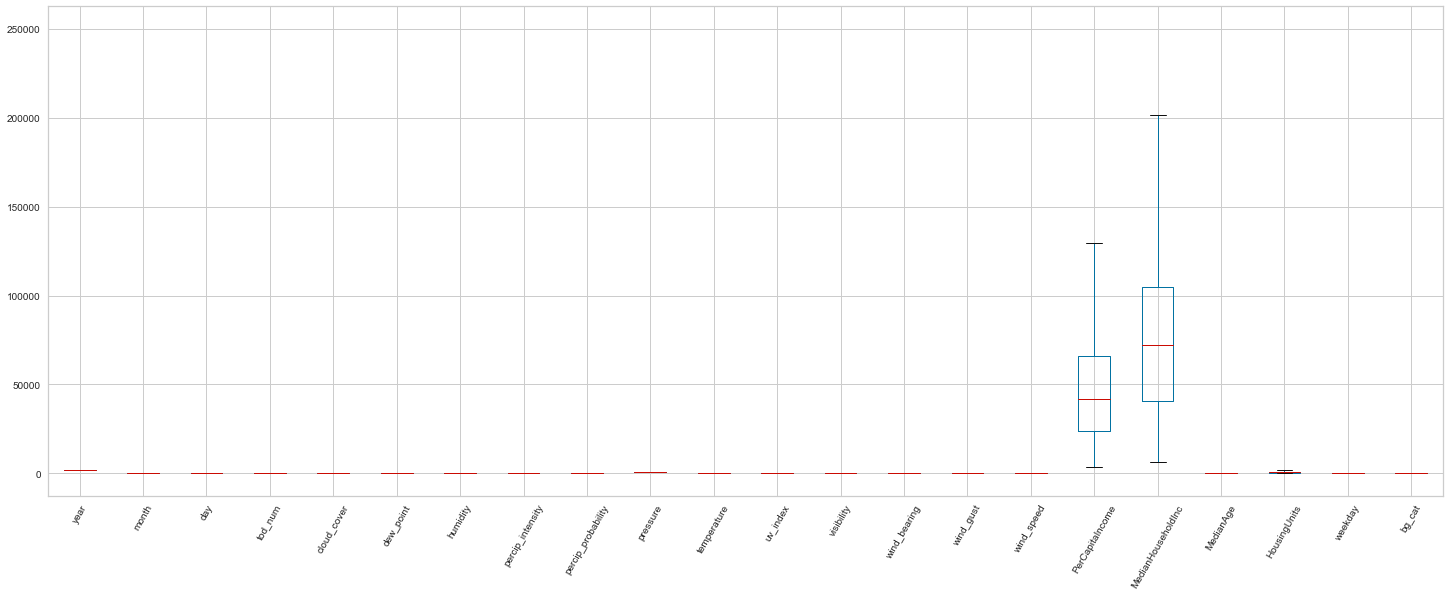

In [28]:
fig = plt.figure(figsize=(25,9))
ax1 = fig.add_subplot(1,1,1)

df_m[feature_cols].boxplot(ax=ax1, rot=60)

In [17]:
scaler = preprocessing.StandardScaler()
#robust = preprocessing.RobustScaler()
#minmax = preprocessing.MinMaxScaler()

scaler_df = pd.DataFrame(scaler.fit_transform(df_m[feature_cols]), columns=feature_cols)
#robust_df = pd.DataFrame(robust.fit_transform(df_m[feature_cols]), columns=feature_cols)
#minmax_df = pd.DataFrame(minmax.fit_transform(df_m[feature_cols]), columns=feature_cols)



In [66]:
scaler.fit_transform(df_m[feature_cols])

array([[-2.38605573, -1.69315361, -0.67881467, ..., -0.05446919,
         1.00233303, -2.0352991 ],
       [-2.38605573, -1.69315361,  0.00652681, ..., -0.05446919,
         0.49785785, -2.0352991 ],
       [-2.38605573, -1.69315361,  1.7198805 , ..., -0.05446919,
         1.00233303, -2.0352991 ],
       ...,
       [ 1.19646545,  1.59387324,  1.37720976, ..., -0.52691435,
        -0.00661733,  1.71008279],
       [ 1.19646545,  1.59387324,  1.49143334, ..., -0.52691435,
         0.49785785,  1.71008279],
       [ 1.19646545,  1.59387324,  1.7198805 , ..., -0.52691435,
         1.50680821,  1.71008279]])

In [69]:
test = scaler.fit(df_m[feature_cols])
test

StandardScaler(copy=True, with_mean=True, with_std=True)

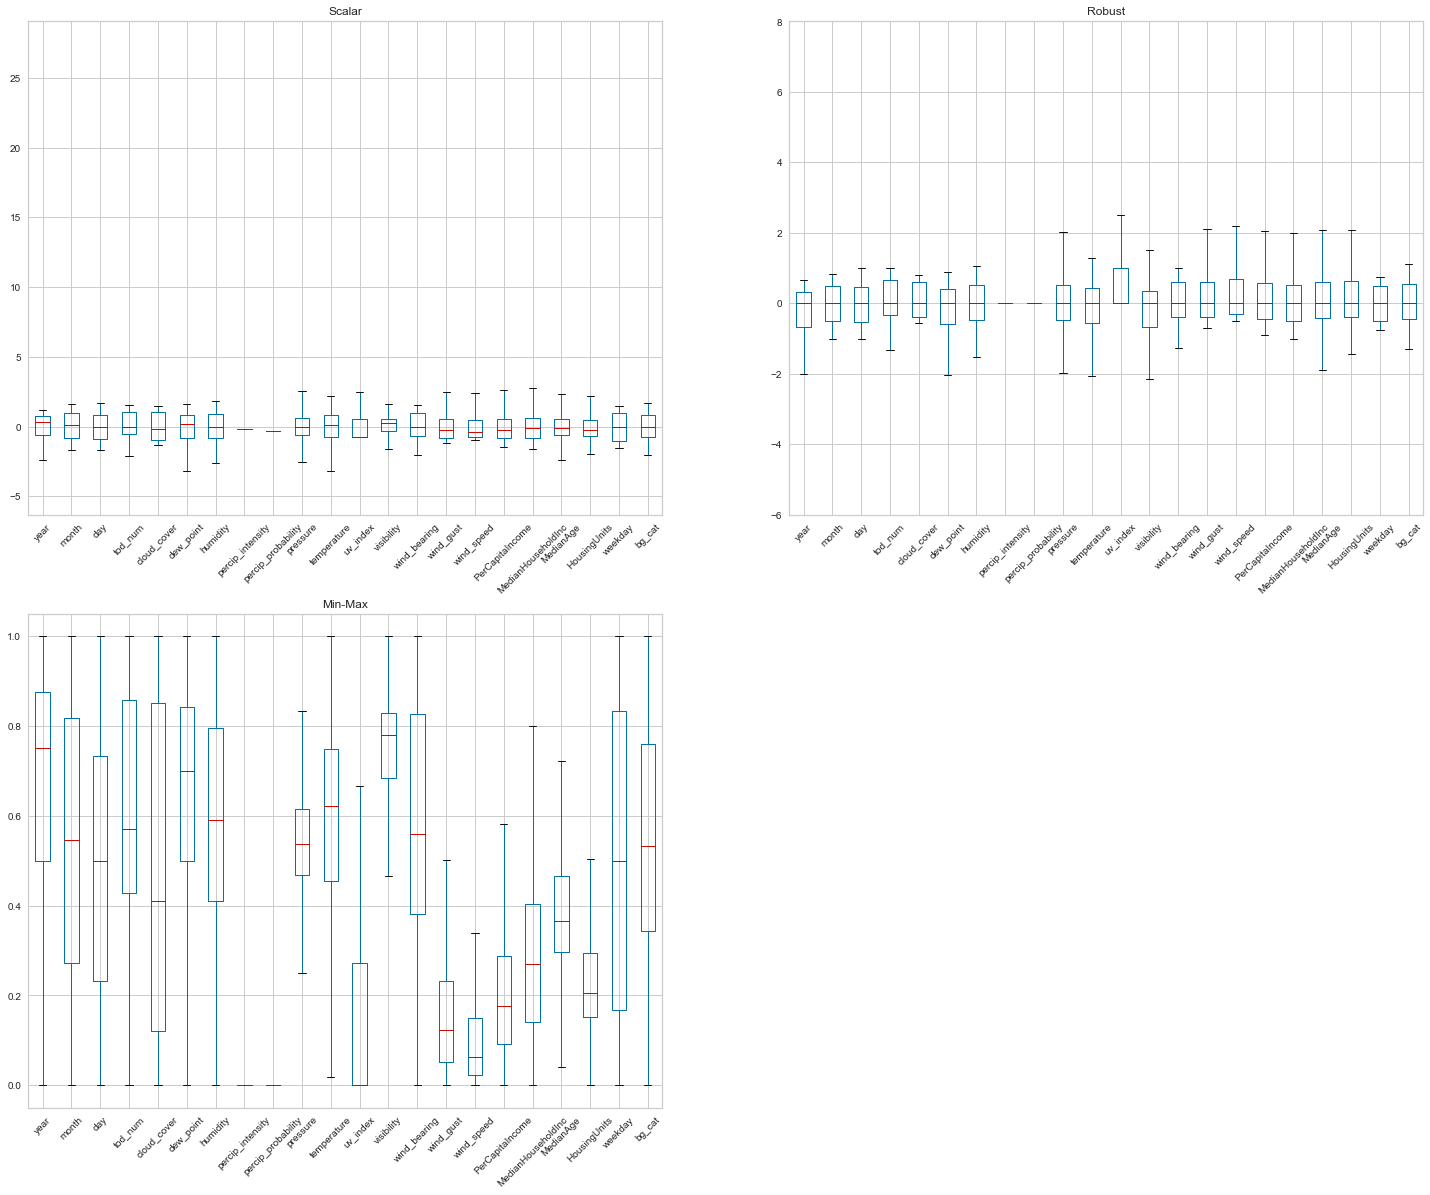

In [30]:
fig = plt.figure(figsize=(25,20))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)

scaler_df.boxplot(ax=ax1)
robust_df.boxplot(ax=ax2)
minmax_df.boxplot(ax=ax3)

ax1_labels = ax1.get_xticklabels()
ax2_labels = ax2.get_xticklabels()
ax3_labels = ax3.get_xticklabels()

ax1.set_xticklabels(ax1_labels,rotation=45)
ax2.set_xticklabels(ax2_labels,rotation=45)
ax3.set_xticklabels(ax3_labels,rotation=45)

ax1.title.set_text('Scalar')
ax2.title.set_text('Robust')
ax3.title.set_text('Min-Max')

plt.show()

In [18]:
features_scaled = scaler_df
target = df_m[target_cols]

In [25]:
# Small sample to make sure the models work
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=30000, train_size=30000)

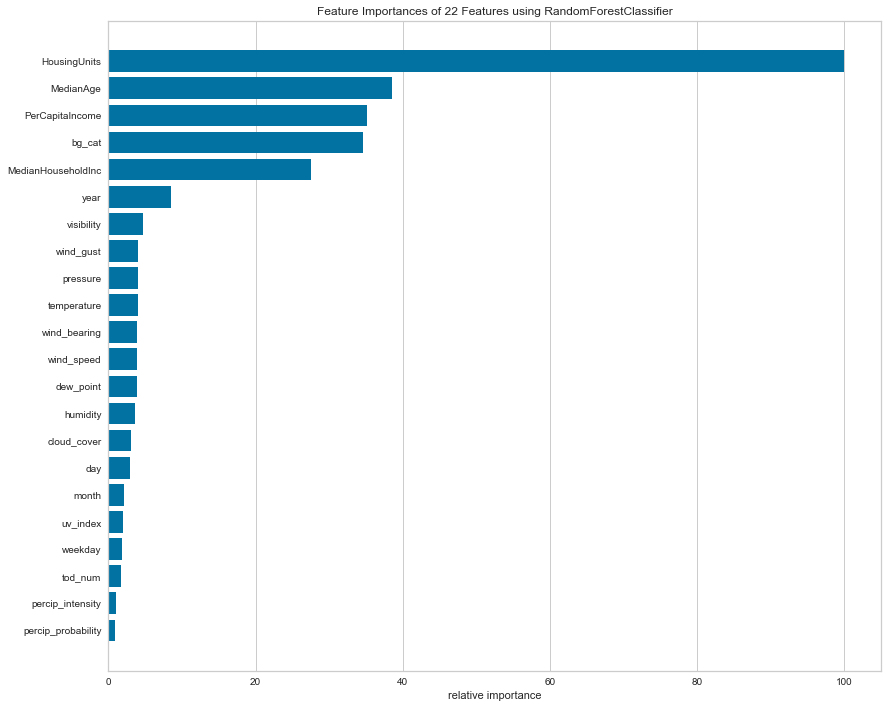

In [28]:
from yellowbrick.features import FeatureImportances

model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, size=(900, 720))

viz.fit(features_scaled, target)
viz.poof()

In [29]:
features_scaled.head()

,year,month,day,tod_num,cloud_cover,dew_point,humidity,percip_intensity,percip_probability,pressure,temperature,uv_index,visibility,wind_bearing,wind_gust,wind_speed,PerCapitaIncome,MedianHouseholdInc,MedianAge,HousingUnits,weekday,bg_cat
0,-2.386056,-1.693154,-0.678815,1.550052,1.444289,-1.500017,-0.437372,-0.185762,-0.330324,1.064815,-1.571021,-0.719109,-0.658113,-1.235360,-0.689097,-0.569594,1.470496,0.027218,1.11945,-0.054469,1.002333,-2.035299
1,-2.386056,-1.693154,0.006527,-0.014663,-1.136755,-2.894015,-1.725311,-0.185762,-0.330324,2.720654,-2.469500,0.138102,-1.974808,0.996122,2.336605,2.902817,1.470496,0.027218,1.11945,-0.054469,0.497858,-2.035299
2,-2.386056,-1.693154,1.719880,-0.536235,-1.301503,-2.252182,-1.349662,-0.185762,-0.330324,0.514283,-1.941651,0.566707,-1.353377,1.076535,1.727775,2.106703,1.470496,0.027218,1.11945,-0.054469,1.002333,-2.035299
3,-2.386056,-1.394333,-1.135709,0.506909,-1.219129,-1.766829,-1.403326,-0.185762,-0.330324,1.516279,-1.333205,-0.719109,-1.494891,-0.752877,-0.827467,-0.626056,1.470496,0.027218,1.11945,-0.054469,0.497858,-2.035299
4,-2.386056,-0.199050,1.034539,0.506909,-1.081839,0.796614,-1.117118,-0.185762,-0.330324,-1.290628,1.520586,-0.290504,-1.205710,0.329358,-0.541502,-0.471726,1.470496,0.027218,1.11945,-0.054469,-0.006617,-2.035299


In [31]:
list(features_scaled.columns)

['year',
 'month',
 'day',
 'tod_num',
 'cloud_cover',
 'dew_point',
 'humidity',
 'percip_intensity',
 'percip_probability',
 'pressure',
 'temperature',
 'uv_index',
 'visibility',
 'wind_bearing',
 'wind_gust',
 'wind_speed',
 'PerCapitaIncome',
 'MedianHouseholdInc',
 'MedianAge',
 'HousingUnits',
 'weekday',
 'bg_cat']

In [33]:
features_scaled_2 = features_scaled.drop(['PerCapitaIncome', 'MedianHouseholdInc', 'MedianAge', 'HousingUnits'], axis=1)

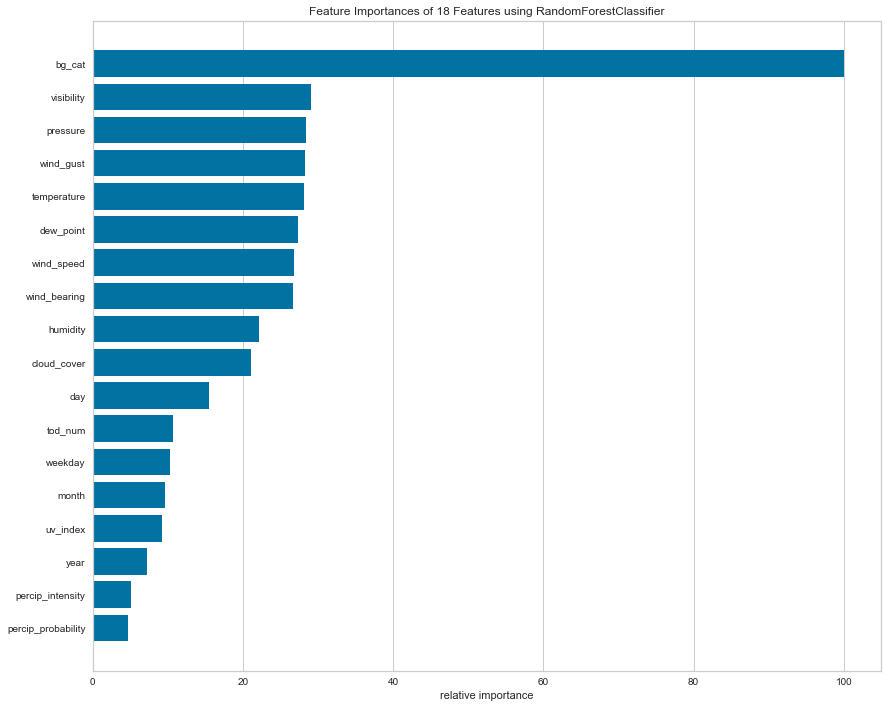

In [34]:
from yellowbrick.features import FeatureImportances



model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, size=(900, 720))

viz.fit(features_scaled_2, target)
viz.poof()

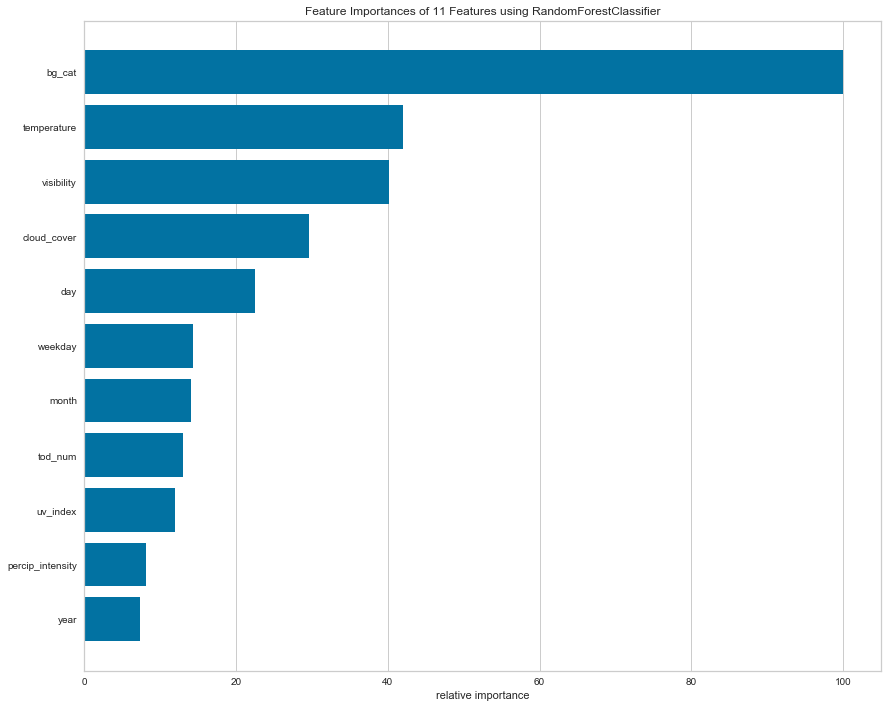

In [37]:
features_scaled_3 = features_scaled_2.drop(['percip_probability', 'dew_point', 'pressure', 'wind_speed', 
                                           'wind_bearing', 'wind_gust', 'humidity'], axis=1)

from yellowbrick.features import FeatureImportances



model = RandomForestClassifier(n_estimators=10)
viz = FeatureImportances(model, size=(900, 720))

viz.fit(features_scaled_3, target)
viz.poof()


In [39]:
from sklearn.feature_selection import RFECV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

X_train, X_test, y_train, y_test = train_test_split(features_scaled_3, target, test_size=30000, train_size=30000)

rmf = RandomForestClassifier()
rfecv = RFECV(estimator=rmf, step=1, cv=StratifiedKFold(9), scoring='accuracy', verbose = 10, n_jobs = -1)
rfecv.fit(X_train , y_train)
optimal_features = rfecv.n_features_

print("Optimal number of features : %d" % rfecv.n_features_)

Fitting estimator with 11 features.
Fitting estimator with 10 features.
Fitting estimator with 9 features.
Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Optimal number of features : 1


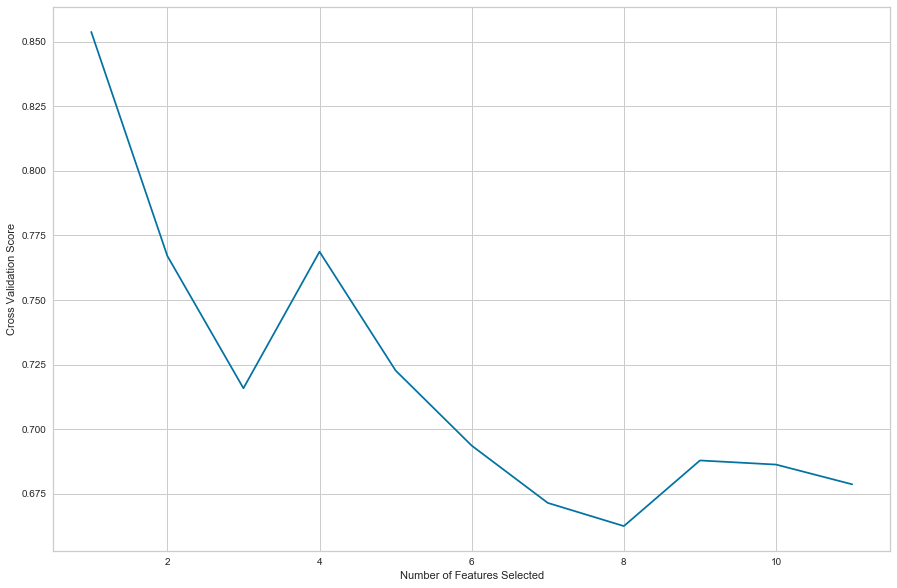

In [40]:
plt.figure(figsize=(15, 10))
plt.xlabel("Number of Features Selected")
plt.ylabel("Cross Validation Score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

### Comparing various classification models

In [23]:
# Adapted from 506 Lab:
def score_model(Xtr, Xte, ytr, yte, estimator):
    """
    Test various estimators.
    """ 
    
    model = estimator
    
    # Instantiate the classification model and visualizer
    model.fit(Xtr, ytr)  
    
    expected  = yte
    predicted = model.predict(Xte)
    
    # Compute and return F1 (harmonic mean of precision and recall)
    print("{}: {}".format(estimator.__class__.__name__, f1_score(expected, predicted, average = 'micro')))
    print('Accuracy score = %0.3f' % accuracy_score(expected, predicted))
    print(confusion_matrix(expected, predicted))

In [26]:
# You get a model!  And you get a model!  Everyone gets a model!

models = [
    KNeighborsClassifier(), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100), ExtraTreesClassifier(),
    DecisionTreeClassifier()
]

for model in models:
    score_model(X_train, X_test, y_train, y_test, model)

KNeighborsClassifier: 0.7089333333333333
Accuracy score = 0.709
[[   29     0     8   477   103]
 [    0   264   125    86     0]
 [    1    49  1694  2634     5]
 [   49     7   891 18550   634]
 [   59     0    34  3570   731]]
BaggingClassifier: 0.9536333333333333
Accuracy score = 0.954
[[  314     0     0   145   158]
 [    0   470     4     1     0]
 [    0    19  4336    26     2]
 [   26    13   266 19769    57]
 [   65     0     8   601  3720]]
ExtraTreesClassifier: 0.9402666666666667
Accuracy score = 0.940
[[  276     0     0   170   171]
 [    0   468     3     4     0]
 [    0    18  4203   162     0]
 [    4    13   249 19845    20]
 [   15     0     7   956  3416]]
RandomForestClassifier: 0.9535
Accuracy score = 0.954
[[  290     0     0   155   172]
 [    0   470     3     2     0]
 [    0    19  4324    40     0]
 [    0    13   255 19811    52]
 [    8     0     7   669  3710]]
ExtraTreesClassifier: 0.9218333333333333
Accuracy score = 0.922
[[  266     0     0   197   1

### Visualize precision, recall, and f1 scores

In [48]:
# Adapted from 506 lab
def visualize_model(Xtr, Xte, ytr, yte, estimator):
    """
    Test various estimators.
    """ 
    #y = LabelEncoder().fit_transform(y)
    #model = Pipeline([
    #     ('one_hot_encoder', OneHotEncoder()), 
    #     ('estimator', estimator)
    #])

    # Instantiate the classification model and visualizer
    visualizer = ClassificationReport(
        model, classes=cats, 
        cmap="Reds", size=(600, 360)
    )
    visualizer.fit(Xtr, ytr)  
    visualizer.score(Xte, yte)
    visualizer.poof()  

#for model in models:
#    visualize_model(X_train, X_test, y_train, y_test, model)

In [63]:
model = BaggingClassifier()
model.fit(X_train, y_train)

expected = y_test
predicted = model.predict(X_test)

print('Bagging Classifier')
print('Accuracy score = %0.3f' % accuracy_score(expected, predicted))
print("{}: {}".format(model.__class__.__name__, f1_score(expected, predicted, average = None)))
confusion_matrix(expected, predicted, labels=cats)

Bagging Classifier
Accuracy score = 0.823
BaggingClassifier: [0.34214619 0.47674419 0.77131503 0.89140819 0.63745436]


array([[21741,    88,  1003,    65,  1231],
       [  224,   220,   293,     0,     4],
       [ 1825,   236,  3055,    13,    74],
       [   60,     1,     5,   246,   216],
       [  801,     0,    26,   180,  4270]])

In [56]:
cats

['Med', 'High', 'Med-High', 'Low', 'Low-Med']

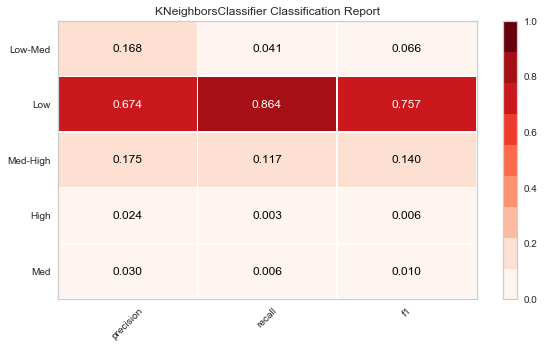

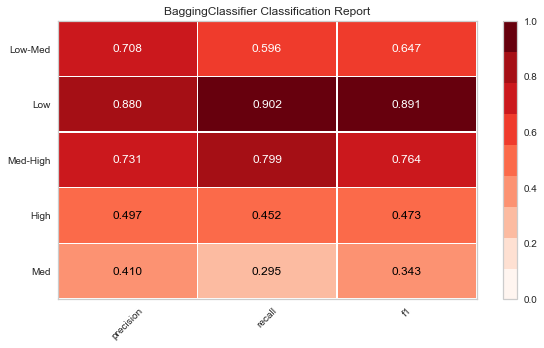

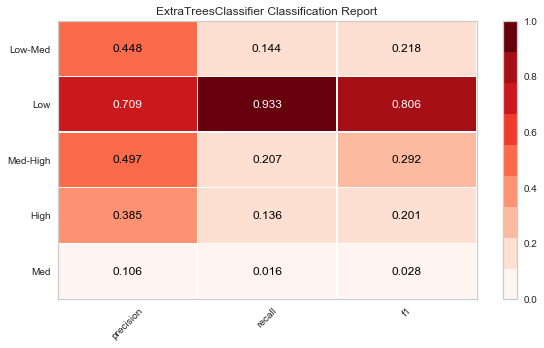

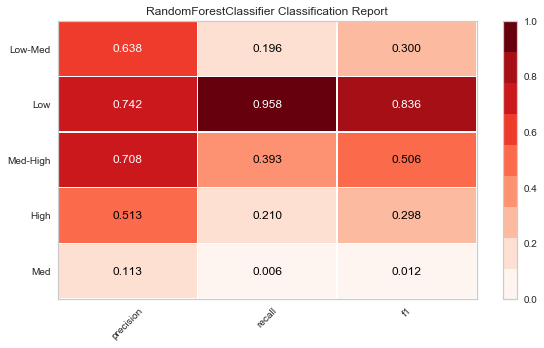

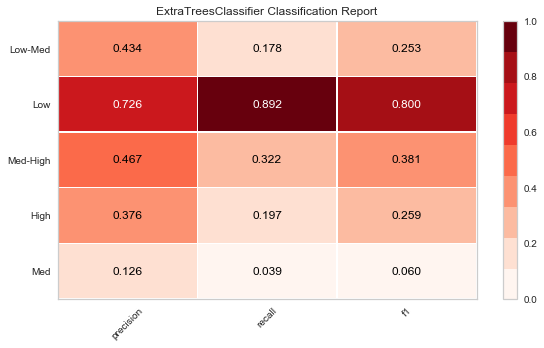

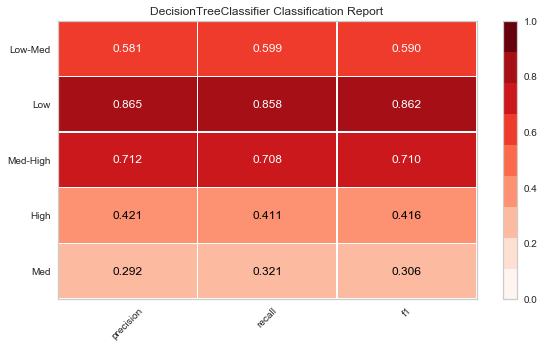

In [53]:
features_final = features_scaled_3[['bg_cat', 'weekday', 'tod_num', 'uv_index', 'temperature', 'day']].copy()

X_train, X_test, y_train, y_test = train_test_split(features_final, target, test_size=.3)

for model in models:
    visualize_model(X_train, X_test, y_train, y_test, model)

In [44]:
features_scaled.head()

,year,month,day,tod_num,cloud_cover,dew_point,humidity,percip_intensity,percip_probability,pressure,temperature,uv_index,visibility,wind_bearing,wind_gust,wind_speed,PerCapitaIncome,MedianHouseholdInc,MedianAge,HousingUnits,weekday,bg_cat
0,-2.386056,-1.693154,-0.678815,1.550052,1.444289,-1.500017,-0.437372,-0.185762,-0.330324,1.064815,-1.571021,-0.719109,-0.658113,-1.235360,-0.689097,-0.569594,1.470496,0.027218,1.11945,-0.054469,1.002333,-2.035299
1,-2.386056,-1.693154,0.006527,-0.014663,-1.136755,-2.894015,-1.725311,-0.185762,-0.330324,2.720654,-2.469500,0.138102,-1.974808,0.996122,2.336605,2.902817,1.470496,0.027218,1.11945,-0.054469,0.497858,-2.035299
2,-2.386056,-1.693154,1.719880,-0.536235,-1.301503,-2.252182,-1.349662,-0.185762,-0.330324,0.514283,-1.941651,0.566707,-1.353377,1.076535,1.727775,2.106703,1.470496,0.027218,1.11945,-0.054469,1.002333,-2.035299
3,-2.386056,-1.394333,-1.135709,0.506909,-1.219129,-1.766829,-1.403326,-0.185762,-0.330324,1.516279,-1.333205,-0.719109,-1.494891,-0.752877,-0.827467,-0.626056,1.470496,0.027218,1.11945,-0.054469,0.497858,-2.035299
4,-2.386056,-0.199050,1.034539,0.506909,-1.081839,0.796614,-1.117118,-0.185762,-0.330324,-1.290628,1.520586,-0.290504,-1.205710,0.329358,-0.541502,-0.471726,1.470496,0.027218,1.11945,-0.054469,-0.006617,-2.035299


In [ ]:
# Small sample to make sure the models work
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=30000, train_size=30000)

In [45]:
#This was the prelim features that were initially identified
features_subset = features_scaled[['month', 'day', 'tod_num', 'humidity', 'temperature', 'uv_index', 
                     'weekday', 'bg_cat']].copy()

month
day
tod_cat
humidity
temperature
uv_index
weekday
bg_cat

In [46]:
# You get a model!  And you get a model!  Everyone gets a model!

# Small sample to make sure the models work
X_train, X_test, y_train, y_test = train_test_split(features_subset, target, test_size=30000, train_size=30000)

models = [
    KNeighborsClassifier(), 
    BaggingClassifier(), ExtraTreesClassifier(n_estimators=100), 
    RandomForestClassifier(n_estimators=100), ExtraTreesClassifier(),
    DecisionTreeClassifier()
]

for model in models:
    score_model(X_train, X_test, y_train, y_test, model)

KNeighborsClassifier: 0.6058
Accuracy score = 0.606
[[    3     2    73   528    23]
 [    2     1    45   429    15]
 [   11     7   542  3681   124]
 [   91    29  1967 17444   663]
 [   23    12   421  3680   184]]
BaggingClassifier: 0.8200666666666667
Accuracy score = 0.820
[[  175     1     4   193   256]
 [    0   213   217    54     8]
 [    2   145  3527   668    23]
 [   93    50  1069 18170   812]
 [  194     2    45  1562  2517]]
ExtraTreesClassifier: 0.6517
Accuracy score = 0.652
[[    1     1    16   590    21]
 [    3     7    20   445    17]
 [   15    14   240  4001    95]
 [   36    22   571 19139   426]
 [   10     3    99  4044   164]]
RandomForestClassifier: 0.6856333333333333
Accuracy score = 0.686
[[    1     0    14   579    35]
 [    2    11    48   422     9]
 [    4    13   714  3586    48]
 [   15     4   330 19609   236]
 [    5     1    65  4015   234]]
ExtraTreesClassifier: 0.6329
Accuracy score = 0.633
[[    9     2    46   528    44]
 [    4    15    67 

In [ ]:
filename = '../JobLib/BaggingClassifier.sav'
joblib.dump(model, filename)

In [ ]:
filename = '../JobLib/BaggingClassifier.sav'
loaded_model = joblib.load(filename)
result = loaded_model.score(X_test, y_test)
print(result)

In [ ]:
result = model.predict(X.iloc[[455]])
result[0]

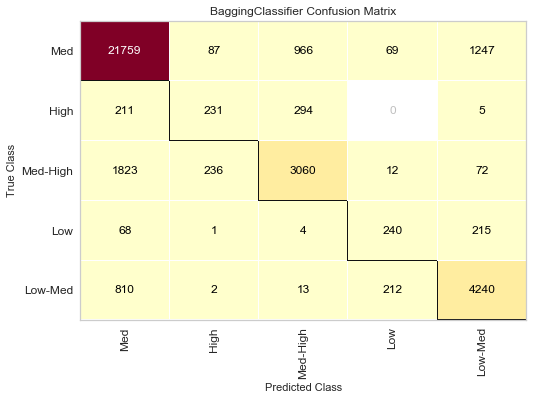

In [59]:
# Each feature of this dataset is an 8x8 pixel image of a handwritten number.
# Digits.data converts these 64 pixels into a single array of features

from yellowbrick.classifier import ConfusionMatrix

X = features_final
y = target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=11)

model = BaggingClassifier()

# The ConfusionMatrix visualizer taxes a model
#cm = ConfusionMatrix(model, classes=[0,1,2,3,4,5,6,7,8,9])
cm = ConfusionMatrix(model, classes=cats)

# Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
cm.fit(X_train, y_train)

# To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
# and then creates the confusion_matrix from scikit-learn.
cm.score(X_test, y_test)

# How did we do?
cm.poof()